# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

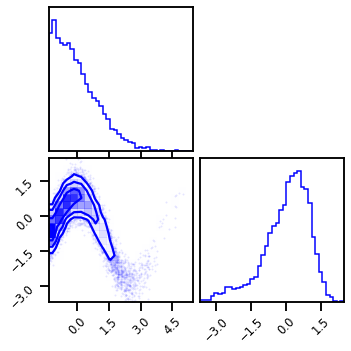

In [3]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
seed = 123
n_samples = 10_000
n_features = 2
data = get_classic(n_samples, seed=123)
scaler = StandardScaler().fit(data)
data = scaler.transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [4]:
X = jnp.array(data, dtype=np.float32)

## DataLoader

In [5]:
from rbig_jax.data import DensityDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds = DensityDataset(np.array(data))

# initialize dataloader
batch_size = 256
shuffle = True

dl = DataLoader(
    ds, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)

## Model

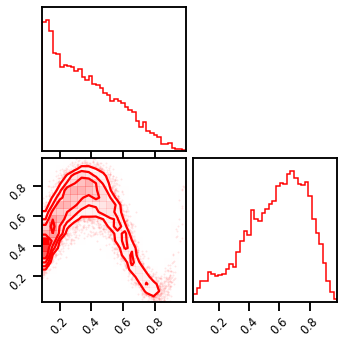

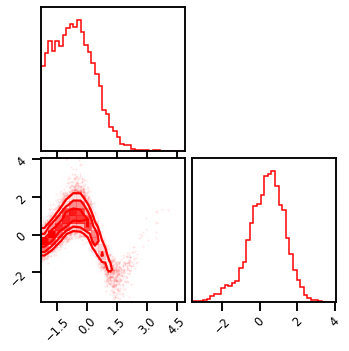

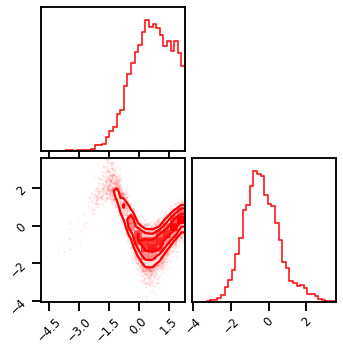

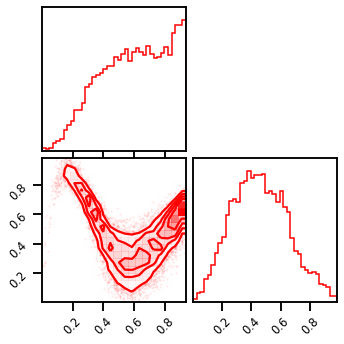

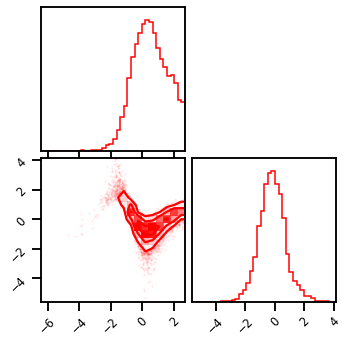

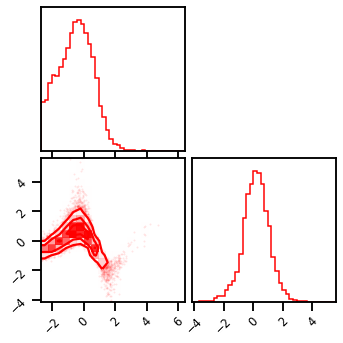

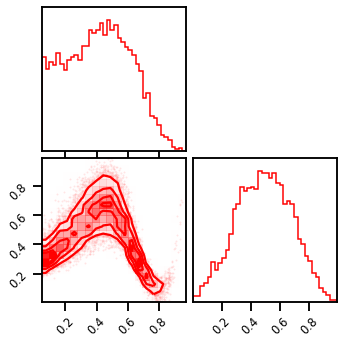

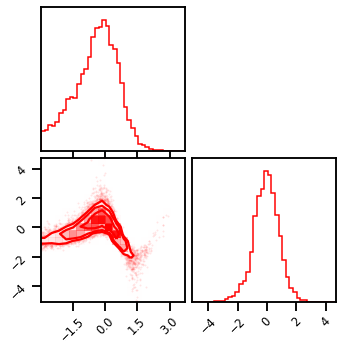

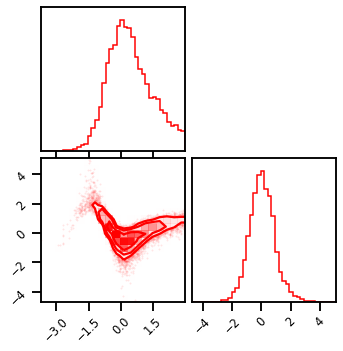

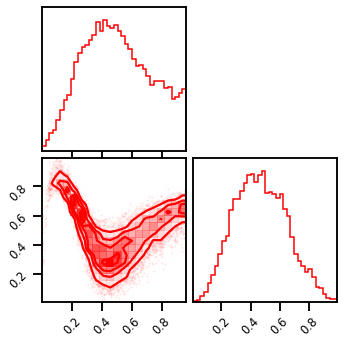

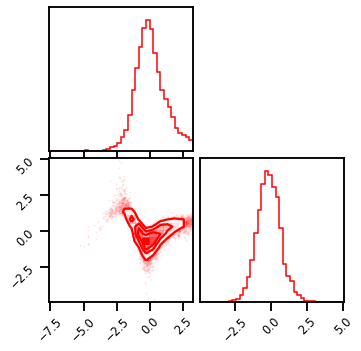

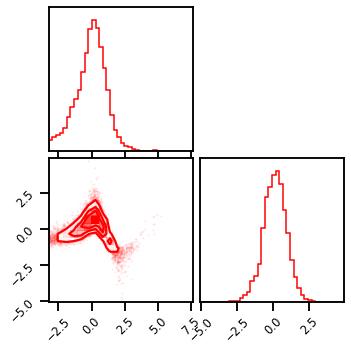

In [7]:


# spline parameters
n_components = 20
n_features = 2
shape = (2,)
key = jax.random.PRNGKey(123)
init_method = "gmm"

# init_mixcdf_f = InitMixtureLogisticCDF(
#     n_components=n_components,
# )
init_mixcdf_f = InitMixtureGaussianCDF(
    n_components=n_components, init_method=init_method
)

# Logit Transformation
logit_bijector = Inverse(Sigmoid())

# Householder Transformation
n_reflections = 10
init_hh_func = InitHouseHolder(n_reflections=n_reflections, method="pca")

# create keys for all inits
n_layers = 4
bijectors = []

rng, *layer_rngs = jax.random.split(KEY, num=n_layers+1)

X_g = X.copy()
for irng in layer_rngs:
    
    # ======================
    # MIXTURECDF
    # ======================
    # create keys for all inits
    irng, icdf_rng = jax.random.split(irng, 2)
    
    layer = init_mixcdf_f(icdf_rng, n_features, X=X_g)
    
    X_g = layer.forward(X_g)

    # plot data
    fig = corner.corner(X_g, color="red", hist_bin_factor=2)

    bijectors.append(layer)
    
    # ======================
    # LOGIT
    # ======================
    
    # create keys for all inits
#     bijectors.append(init_logit_func(irng, n_features))
    layer = logit_bijector
    X_g = layer.forward(X_g)
    # plot data
    fig = corner.corner(X_g, color="red", hist_bin_factor=2)
    bijectors.append(layer)
    
    # ======================
    # HOUSEHOLDER
    # ======================
    # create keys for all inits
    irng, hh_rng = jax.random.split(irng, 2)
    layer = init_hh_func(hh_rng, n_features, X=X)
#     X_g = jnp.dot(X, layer.V)
    X_g = layer.forward(X_g)
    # plot data
    fig = corner.corner(X_g, color="red", hist_bin_factor=2)
    bijectors.append(layer)

# # create chain
# chain_bijectors = BijectorChain(bijectors=bijectors)

In [ ]:
# from jax.scipy.special import sof

In [8]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# create base dist
base_dist = Normal(jnp.zeros((n_features,)),jnp.ones((n_features,)))

# create flow model
gf_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

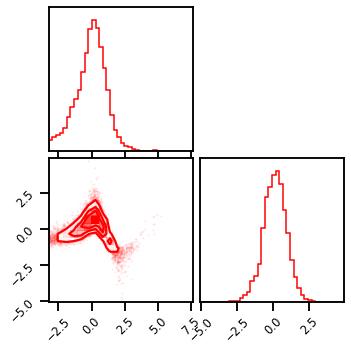

In [9]:
X_g = gf_model.forward(X)

# plot data
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

#### Training

In [ ]:
from jax.experimental import optimizers
from rbig_jax.training.parametric import init_train_op, init_gf_train_op, train_model


# lr = 0.05
lr = 0.005
optimizer = optimizers.adam(step_size=lr)
jitted = True
# epochs = 150
epochs = 100

# train model
final_bijector, losses = train_model(gf_model, dl, epochs=epochs, optimizer=optimizer, lr=lr, jitted=jitted)

  0%|          | 0/100 [00:00<?, ?it/s]

### Results

#### Losses

In [ ]:
plt.plot(losses)

#### Latent Space

In [ ]:
%%time
X_trans = final_bijector.forward(data)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transform

In [ ]:
%%time

X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

### Log Probability

In [ ]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points
xyinput = generate_2d_grid(X, 500, buffer=0.2)

# calculate log probability
X_log_prob = final_bijector.score_samples(xyinput)

#### Plot: Original Density

In [ ]:
# Original Density
n_samples = 1_000_000
n_features = 2
X_plot = get_classic(n_samples, seed=123)
X_plot = scaler.transform(X_plot)

# Estimated Density
cmap = cm.magma # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)



cmap = cm.magma # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
h = ax[0].hist2d(X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0., vmax=1.)
ax[0].set_title("True Density")
ax[0].set(xlim=[X_plot[:, 0].min(), X_plot[:,0].max()], ylim=[X_plot[:,1].min(), X_plot[:,1].max()])

h1 = ax[1].scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0)
ax[1].set(xlim=[xyinput[:, 0].min(), xyinput[:,0].max()], ylim=[xyinput[:,1].min(), xyinput[:,1].max()])
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Sampling

In [ ]:
%%time
# generate samples in the latent domain
n_gen_samples = 10_000

X_g_samples = Normal(0.0, 1.0).sample(seed=123, sample_shape=(n_gen_samples, 2))

X_samples = final_bijector.inverse(X_g_samples)

# X_samples = np.array(gf_model.inverse(X_g_samples.block_until_ready()))

# # inverse transformation
# f = jax.jit(gf_model.inverse)
# X_samples = np.array(f(X_g_samples))

# # This way works too! But slower
# # generate samples in the latent domain
# n_gen_samples = 10_000

# # # inverse transformation
# X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

In [ ]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

In [ ]:
len(final_bijector.bijectors)

In [ ]:
3 % 3 

In [ ]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    

In [ ]:

X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=10)
ax.set_aspect('equal', 'box')
plt.tight_layout()